# Deep Learning
## Assignment 4
Previously in 2_fullyconnected.ipynb and 3_regularization.ipynb, we trained fully connected networks to classify notMNIST characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
* convolutions need the image data formatted as a cube (width by height by #channels)
* labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels =  tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset =  tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.615072
Minibatch accuracy: 12.5%
Validation accuracy: 12.3%
Minibatch loss at step 50: 1.175470
Minibatch accuracy: 63.3%
Validation accuracy: 70.8%
Minibatch loss at step 100: 0.961055
Minibatch accuracy: 71.1%
Validation accuracy: 75.1%
Minibatch loss at step 150: 0.958802
Minibatch accuracy: 77.3%
Validation accuracy: 77.3%
Minibatch loss at step 200: 0.763988
Minibatch accuracy: 79.7%
Validation accuracy: 79.3%
Minibatch loss at step 250: 0.611423
Minibatch accuracy: 82.8%
Validation accuracy: 80.5%
Minibatch loss at step 300: 0.873709
Minibatch accuracy: 74.2%
Validation accuracy: 80.6%
Minibatch loss at step 350: 0.744563
Minibatch accuracy: 80.5%
Validation accuracy: 80.9%
Minibatch loss at step 400: 0.654189
Minibatch accuracy: 82.8%
Validation accuracy: 81.7%
Minibatch loss at step 450: 0.525873
Minibatch accuracy: 85.2%
Validation accuracy: 81.7%
Minibatch loss at step 500: 0.685454
Minibatch accuracy: 82.0%
Validation accuracy: 82.1%
M

### Problem 1
The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.


In [11]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels),name="training_data")
    labels =  tf.placeholder(tf.float32, shape=(None, num_labels), name="training_labels")
    tf_valid_dataset = tf.constant(valid_dataset, name="valid_data")
    tf_test_dataset =  tf.constant(test_dataset, name="test_data")
    tf_test_labels =  tf.constant(test_labels, name="test_labels")

    def weight_variable(shape,name):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)

    def bias_variable(shape, name):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
 
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth], "weight_conv1")
    b_conv1 = bias_variable([depth],"bias_conv1") 
    
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 32, 64],"weight_conv2")
    b_conv2 = bias_variable([64],"bias_conv2")

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_full_connect1")
    b_fc1 = bias_variable([1024],"B_full_connect1")

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10],"W_full_connect2")
    b_fc2 = bias_variable([10],"B_full_connect2")

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

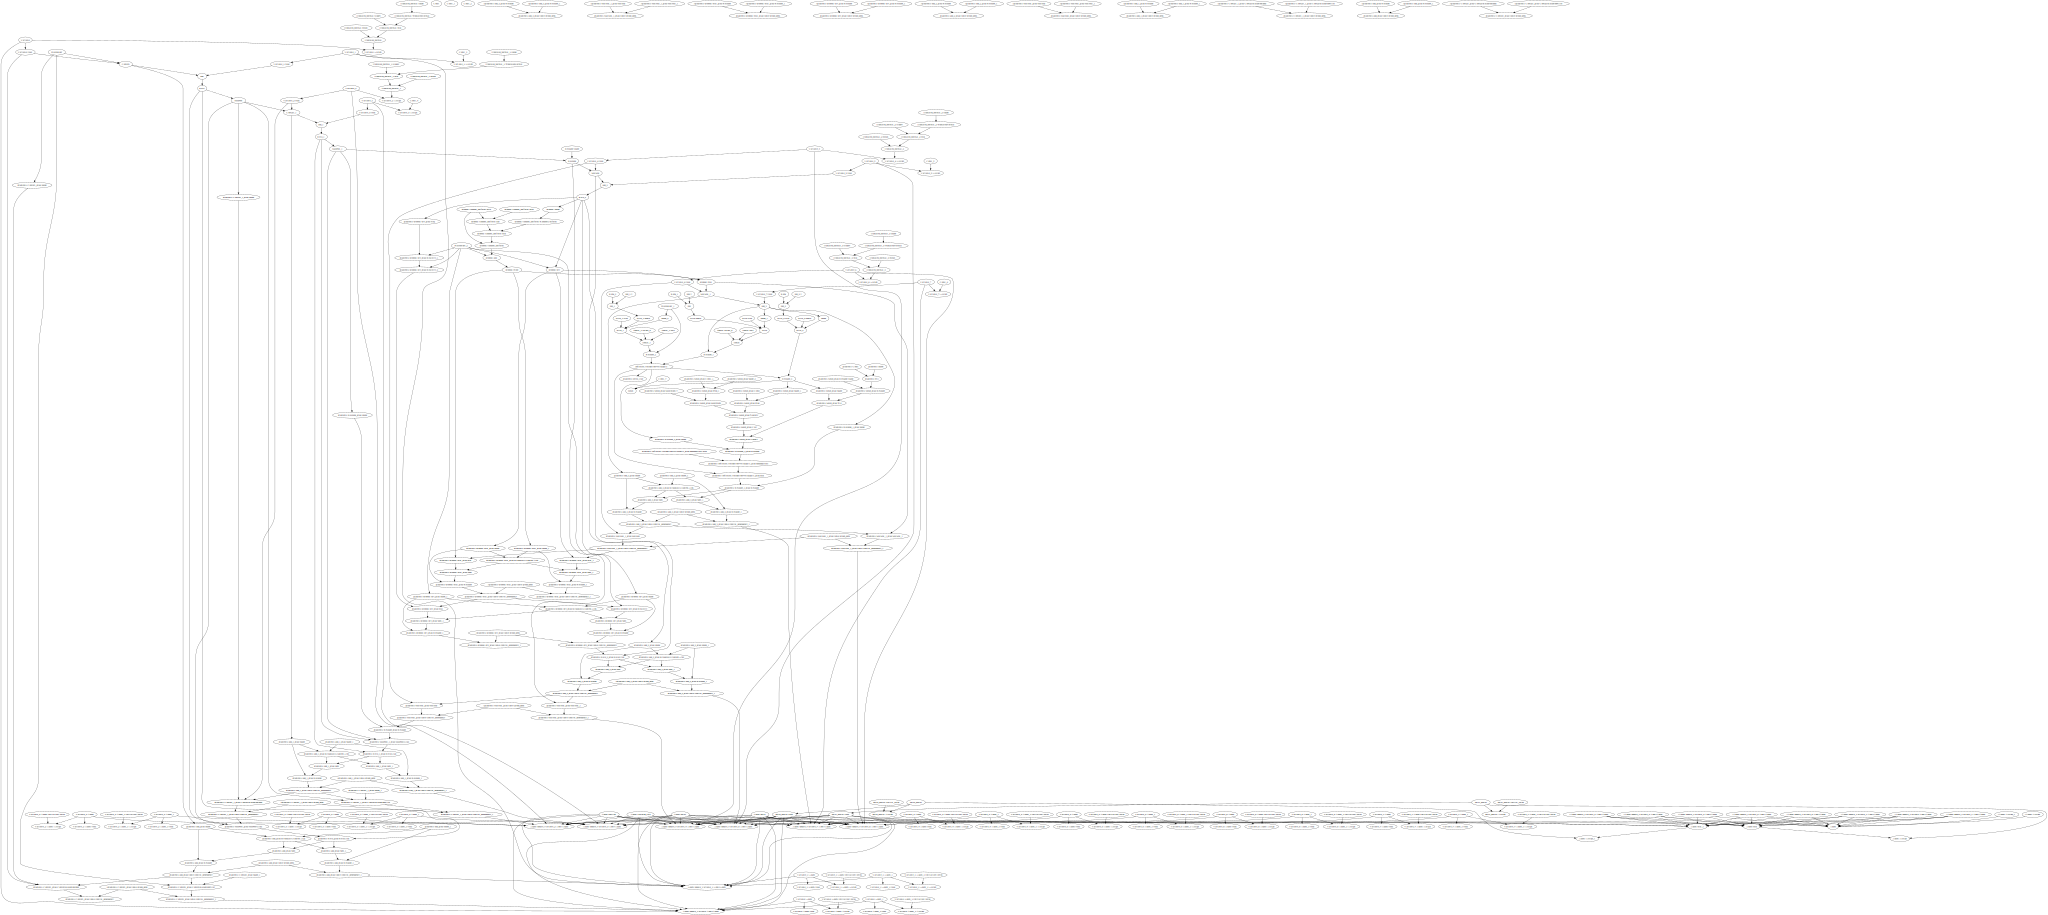

In [8]:
from graphviz import Digraph

dot = Digraph()

for n in graph.as_graph_def().node:
    # Each node has a name and a label. The name identifies the node
    # while the label is what will be displayed in the graph.
    # We're using the name as a label for simplicity.
    dot.node(n.name, label=n.name)
    
    for i in n.input:
        # Edges are determined by the names of the nodes
        dot.edge(i, n.name)
        
# Jupyter can automatically display the DOT graph,
# which allows us to just return it as a value.
dot

In [9]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(graph)

In [6]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {data : batch_data, labels : batch_labels, keep_prob: 0.5}
    session.run([train_step], feed_dict=feed_dict)
    if (step % 100 == 0):
        train_accuracy = accuracy.eval(feed_dict=feed_dict)
        print('step %d, training accuracy %g' % (step, train_accuracy))
  print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))

Initialized
step 0, training accuracy 0.0390625
step 100, training accuracy 0.601562
step 200, training accuracy 0.734375
step 300, training accuracy 0.695312
step 400, training accuracy 0.796875
step 500, training accuracy 0.84375
step 600, training accuracy 0.820312
step 700, training accuracy 0.820312
step 800, training accuracy 0.890625
step 900, training accuracy 0.898438
step 1000, training accuracy 0.851562
step 1100, training accuracy 0.867188
step 1200, training accuracy 0.8125
step 1300, training accuracy 0.84375
step 1400, training accuracy 0.867188
step 1500, training accuracy 0.890625
step 1600, training accuracy 0.867188
step 1700, training accuracy 0.898438
step 1800, training accuracy 0.875
step 1900, training accuracy 0.851562
step 2000, training accuracy 0.867188
step 2100, training accuracy 0.867188
step 2200, training accuracy 0.8125
step 2300, training accuracy 0.859375
step 2400, training accuracy 0.828125
step 2500, training accuracy 0.882812
step 2600, training 

### Problem 2
Try to get the best performance you can using a convolutional net. Look for example at the classic LeNet5 architecture, adding Dropout, and/or adding learning rate decay.

In [11]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 64
beta = 0.01

graph = tf.Graph()

with graph.as_default():

    # Input data.
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    labels =  tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset =  tf.constant(test_dataset)
    tf_test_labels =  tf.constant(test_labels)

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
 
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth]) 
    
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
    loss = cross_entropy+\
        beta*tf.nn.l2_loss(W_conv1) +\
        beta*tf.nn.l2_loss(b_conv1) +\
        beta*tf.nn.l2_loss(W_conv2) +\
        beta*tf.nn.l2_loss(b_conv2) +\
        beta*tf.nn.l2_loss(W_fc1) +\
        beta*tf.nn.l2_loss(b_fc1) +\
        beta*tf.nn.l2_loss(W_fc2) +\
        beta*tf.nn.l2_loss(b_fc2)
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(1e-4, global_step, 10000, 0.9, staircase=True)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
#     train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {data : batch_data, labels : batch_labels, keep_prob: 0.5}
    session.run([train_step], feed_dict=feed_dict)
    if (step % 100 == 0):
        train_accuracy = accuracy.eval(feed_dict=feed_dict)
        print('step %d, training accuracy %g' % (step, train_accuracy))
        print('valid accuracy %g' % accuracy.eval(feed_dict={data: valid_dataset, labels: valid_labels, keep_prob: 1.0}))
  print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))

Initialized
step 0, training accuracy 0.171875
valid accuracy 0.1544
step 100, training accuracy 0.59375
valid accuracy 0.7639
step 200, training accuracy 0.695312
valid accuracy 0.7984
step 300, training accuracy 0.734375
valid accuracy 0.806
step 400, training accuracy 0.773438
valid accuracy 0.819
step 500, training accuracy 0.773438
valid accuracy 0.8219
step 600, training accuracy 0.789062
valid accuracy 0.8282
step 700, training accuracy 0.851562
valid accuracy 0.8348
step 800, training accuracy 0.890625
valid accuracy 0.8398
step 900, training accuracy 0.859375
valid accuracy 0.8428
step 1000, training accuracy 0.851562
valid accuracy 0.8473
step 1100, training accuracy 0.867188
valid accuracy 0.8481
step 1200, training accuracy 0.804688
valid accuracy 0.8533
step 1300, training accuracy 0.820312
valid accuracy 0.8555
step 1400, training accuracy 0.84375
valid accuracy 0.856
step 1500, training accuracy 0.898438
valid accuracy 0.859
step 1600, training accuracy 0.867188
valid ac

In [5]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 64
beta = 0.01

graph = tf.Graph()

with graph.as_default():

    # Input data.
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    labels =  tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset =  tf.constant(test_dataset)
    tf_test_labels =  tf.constant(test_labels)

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
 
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth]) 
    
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
#     loss = cross_entropy+\
#         beta*tf.nn.l2_loss(W_conv1) +\
#         beta*tf.nn.l2_loss(b_conv1) +\
#         beta*tf.nn.l2_loss(W_conv2) +\
#         beta*tf.nn.l2_loss(b_conv2) +\
#         beta*tf.nn.l2_loss(W_fc1) +\
#         beta*tf.nn.l2_loss(b_fc1) +\
#         beta*tf.nn.l2_loss(W_fc2) +\
#         beta*tf.nn.l2_loss(b_fc2)
    
#     global_step = tf.Variable(0)  # count the number of steps taken.
#     learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.9, staircase=True)
#     train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
    
#     train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {data : batch_data, labels : batch_labels, keep_prob: 0.5}
    session.run([train_step], feed_dict=feed_dict)
    if (step % 100 == 0):
        train_accuracy = accuracy.eval(feed_dict=feed_dict)
        print('step %d, training accuracy %g' % (step, train_accuracy))
        print('valid accuracy %g' % accuracy.eval(feed_dict={data: valid_dataset, labels: valid_labels, keep_prob: 1.0}))
        print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))
#   print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))

Initialized
step 0, training accuracy 0.132812
valid accuracy 0.131
test accuracy 0.1317
step 100, training accuracy 0.734375
valid accuracy 0.8029
test accuracy 0.8745
step 200, training accuracy 0.820312
valid accuracy 0.8176
test accuracy 0.8854
step 300, training accuracy 0.773438
valid accuracy 0.8321
test accuracy 0.9008
step 400, training accuracy 0.851562
valid accuracy 0.8418
test accuracy 0.912
step 500, training accuracy 0.84375
valid accuracy 0.8483
test accuracy 0.9142
step 600, training accuracy 0.84375
valid accuracy 0.847
test accuracy 0.9169
step 700, training accuracy 0.859375
valid accuracy 0.852
test accuracy 0.9215
step 800, training accuracy 0.898438
valid accuracy 0.8559
test accuracy 0.9249
step 900, training accuracy 0.875
valid accuracy 0.8581
test accuracy 0.9259
step 1000, training accuracy 0.882812
valid accuracy 0.8604
test accuracy 0.9286
step 1100, training accuracy 0.875
valid accuracy 0.8675
test accuracy 0.9332
step 1200, training accuracy 0.851562
va

In [5]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 64
beta = 0.01

graph = tf.Graph()

with graph.as_default():

    # Input data.
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    labels =  tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset =  tf.constant(test_dataset)
    tf_test_labels =  tf.constant(test_labels)

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
 
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth]) 
    
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
#     loss = cross_entropy+\
#         beta*tf.nn.l2_loss(W_conv1) +\
#         beta*tf.nn.l2_loss(b_conv1) +\
#         beta*tf.nn.l2_loss(W_conv2) +\
#         beta*tf.nn.l2_loss(b_conv2) +\
#         beta*tf.nn.l2_loss(W_fc1) +\
#         beta*tf.nn.l2_loss(b_fc1) +\
#         beta*tf.nn.l2_loss(W_fc2) +\
#         beta*tf.nn.l2_loss(b_fc2)
    
#     global_step = tf.Variable(0)  # count the number of steps taken.
#     learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.9, staircase=True)
#     train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
#     train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {data : batch_data, labels : batch_labels, keep_prob: 0.5}
    session.run([train_step], feed_dict=feed_dict)
    if (step % 100 == 0):
        train_accuracy = accuracy.eval(feed_dict=feed_dict)
        print('step %d, training accuracy %g' % (step, train_accuracy))
        print('valid accuracy %g' % accuracy.eval(feed_dict={data: valid_dataset, labels: valid_labels, keep_prob: 1.0}))
        print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))
#   print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))

Initialized
step 0, training accuracy 0.109375
valid accuracy 0.1235
test accuracy 0.1245
step 100, training accuracy 0.578125
valid accuracy 0.77
test accuracy 0.8451
step 200, training accuracy 0.765625
valid accuracy 0.7964
test accuracy 0.8715
step 300, training accuracy 0.664062
valid accuracy 0.8092
test accuracy 0.8809
step 400, training accuracy 0.796875
valid accuracy 0.8185
test accuracy 0.8908
step 500, training accuracy 0.820312
valid accuracy 0.8238
test accuracy 0.8937
step 600, training accuracy 0.78125
valid accuracy 0.8301
test accuracy 0.8996
step 700, training accuracy 0.890625
valid accuracy 0.8362
test accuracy 0.9036
step 800, training accuracy 0.867188
valid accuracy 0.8382
test accuracy 0.9064
step 900, training accuracy 0.882812
valid accuracy 0.8394
test accuracy 0.908
step 1000, training accuracy 0.84375
valid accuracy 0.8434
test accuracy 0.9117
step 1100, training accuracy 0.851562
valid accuracy 0.8475
test accuracy 0.9147
step 1200, training accuracy 0.84

valid accuracy 0.9073
test accuracy 0.9639
step 10300, training accuracy 0.90625
valid accuracy 0.909
test accuracy 0.9635
step 10400, training accuracy 0.96875
valid accuracy 0.9094
test accuracy 0.9642
step 10500, training accuracy 0.9375
valid accuracy 0.9084
test accuracy 0.9645
step 10600, training accuracy 0.953125
valid accuracy 0.9094
test accuracy 0.9635
step 10700, training accuracy 0.960938
valid accuracy 0.9093
test accuracy 0.9639
step 10800, training accuracy 0.914062
valid accuracy 0.908
test accuracy 0.9632
step 10900, training accuracy 0.90625
valid accuracy 0.9067
test accuracy 0.9628
step 11000, training accuracy 0.953125
valid accuracy 0.9078
test accuracy 0.963
step 11100, training accuracy 0.890625
valid accuracy 0.9085
test accuracy 0.9647
step 11200, training accuracy 0.921875
valid accuracy 0.9101
test accuracy 0.965
step 11300, training accuracy 0.921875
valid accuracy 0.9093
test accuracy 0.9649
step 11400, training accuracy 0.9375
valid accuracy 0.9109
test 

In [4]:
batch_size = 128
patch_size = 5
depth = 32
num_hidden = 64
beta = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data.
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    labels =  tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset =  tf.constant(test_dataset)
    tf_test_labels =  tf.constant(test_labels)

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
 
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth]) 
    
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))
    loss = cross_entropy+\
        beta*tf.nn.l2_loss(W_conv1) +\
        beta*tf.nn.l2_loss(b_conv1) +\
        beta*tf.nn.l2_loss(W_conv2) +\
        beta*tf.nn.l2_loss(b_conv2) +\
        beta*tf.nn.l2_loss(W_fc1) +\
        beta*tf.nn.l2_loss(b_fc1) +\
        beta*tf.nn.l2_loss(W_fc2) +\
        beta*tf.nn.l2_loss(b_fc2)
    
#     global_step = tf.Variable(0)  # count the number of steps taken.
#     learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.9, staircase=True)
#     train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
#     train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {data : batch_data, labels : batch_labels, keep_prob: 0.5}
    session.run([train_step], feed_dict=feed_dict)
    if (step % 100 == 0):
        train_accuracy = accuracy.eval(feed_dict=feed_dict)
        print('step %d, training accuracy %g' % (step, train_accuracy))
        print('valid accuracy %g' % accuracy.eval(feed_dict={data: valid_dataset, labels: valid_labels, keep_prob: 1.0}))
        print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))
#   print('test accuracy %g' % accuracy.eval(feed_dict={data: test_dataset, labels: test_labels, keep_prob: 1.0}))

Initialized
step 0, training accuracy 0.125
valid accuracy 0.1021
test accuracy 0.1012
step 100, training accuracy 0.578125
valid accuracy 0.758
test accuracy 0.8251
step 200, training accuracy 0.695312
valid accuracy 0.7948
test accuracy 0.8683
step 300, training accuracy 0.679688
valid accuracy 0.8078
test accuracy 0.878
step 400, training accuracy 0.789062
valid accuracy 0.8222
test accuracy 0.8963
step 500, training accuracy 0.820312
valid accuracy 0.826
test accuracy 0.9008
step 600, training accuracy 0.789062
valid accuracy 0.8301
test accuracy 0.9042
step 700, training accuracy 0.820312
valid accuracy 0.838
test accuracy 0.9114
step 800, training accuracy 0.882812
valid accuracy 0.8429
test accuracy 0.9124
step 900, training accuracy 0.867188
valid accuracy 0.8452
test accuracy 0.9147
step 1000, training accuracy 0.859375
valid accuracy 0.8495
test accuracy 0.9188
step 1100, training accuracy 0.859375
valid accuracy 0.8505
test accuracy 0.92
step 1200, training accuracy 0.828125

step 10200, training accuracy 0.9375
valid accuracy 0.9071
test accuracy 0.9618
step 10300, training accuracy 0.90625
valid accuracy 0.9099
test accuracy 0.964
step 10400, training accuracy 0.945312
valid accuracy 0.9087
test accuracy 0.964
step 10500, training accuracy 0.953125
valid accuracy 0.9088
test accuracy 0.9628
step 10600, training accuracy 0.960938
valid accuracy 0.9094
test accuracy 0.9633
step 10700, training accuracy 0.96875
valid accuracy 0.9089
test accuracy 0.964
step 10800, training accuracy 0.914062
valid accuracy 0.9079
test accuracy 0.9631
step 10900, training accuracy 0.9375
valid accuracy 0.9092
test accuracy 0.9632
step 11000, training accuracy 0.921875
valid accuracy 0.9112
test accuracy 0.9639
step 11100, training accuracy 0.859375
valid accuracy 0.91
test accuracy 0.9632
step 11200, training accuracy 0.9375
valid accuracy 0.9081
test accuracy 0.9638
step 11300, training accuracy 0.945312
valid accuracy 0.9083
test accuracy 0.9652
step 11400, training accuracy